# Deep Music Genre Classification
In this blog post, I will use PyTorch to train neural networks that classify music genre based on lyrics and some engineered features that describe song attributes. 

## Data Preparation
To start off, I will read the data and turn them into `Dataset` objects that can be accessed by PyTorch.

In [ ]:
# download dataset
import pandas as pd

url = "https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/tcc_ceds_music.csv"
df = pd.read_csv(url)
engineered_features = ['dating', 'violence', 'world/life', 'night/time','shake the audience','family/gospel', 'romantic', 'communication','obscene', 'music', 'movement/places', 'light/visual perceptions','family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability','loudness', 'acousticness', 'instrumentalness', 'valence', 'energy'] 

In [ ]:
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


I will look at three genres: hip hop, country, and rock. Since the `genre` labels are strings, I will encode them with integers. 

In [ ]:
genres = {
    "hip hop": 0, 
    "country": 1, 
    "rock": 2
}

df = df[df["genre"].apply(lambda x: x in genres.keys())]
df["genre"] = df["genre"].apply(genres.get)
df.head()

<ipython-input-2-2682094cf579>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["genre"] = df["genre"].apply(genres.get)


,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
7042,20290,lefty frizzell,if you've got the money i've got the time,1950,1,money time honky tonkin time night spot dance ...,59,0.022813,0.001074,0.001074,...,0.001074,0.001074,0.523448,0.655488,0.833333,0.000095,0.955688,0.392373,night/time,1.0
7043,20292,lefty frizzell,i want to be with you always,1950,1,lose blue heart stay go sing song wanna dear n...,24,0.002288,0.002288,0.002288,...,0.205663,0.091285,0.705405,0.594980,0.777108,0.000229,0.717642,0.226202,music,1.0
7044,20293,lefty frizzell,how long will it take (to stop loving you),1950,1,long count star long climb mar long world stan...,34,0.001595,0.001595,0.119458,...,0.001595,0.001595,0.780136,0.583109,0.892570,0.000052,0.706307,0.180155,night/time,1.0
7045,20297,lefty frizzell,look what thoughts will do,1950,1,think love think love look thoughts today wear...,44,0.001253,0.001253,0.308536,...,0.001253,0.039916,0.716235,0.609697,0.734939,0.000000,0.703215,0.249226,world/life,1.0
7046,20300,lefty frizzell,treasure untold,1950,1,dream eye blue love forever long dear want nea...,36,0.001698,0.001698,0.140714,...,0.001698,0.001698,0.703238,0.648848,0.685743,0.000000,0.384790,0.219195,romantic,1.0


In [ ]:
# create Dataset class using features of interest
from torch.utils.data import Dataset, DataLoader
import torch

engineered_feature_indices = [df.columns.get_loc(col_name) for col_name in engineered_features]

class TextDataFromDF(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, index): # get lyrics, engineered features, and genre labels
        lyrics = self.df.iloc[index, 5]
        engineered = self.df.iloc[index, engineered_feature_indices].tolist()
        labels = self.df.iloc[index, 4]
        return lyrics, engineered, labels

    def __len__(self):
        return len(self.df)                

In [ ]:
# train-test split
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,shuffle = True, test_size = 0.2)
train_data = TextDataFromDF(df_train)
test_data  = TextDataFromDF(df_test)


Each element of the dataset is a tuple containing the lyrics, engineered features, and integer labels.

In [ ]:
train_data[0]

('feet feet fight missiles spear thirtyone seventeen soldier thousand years catholic hindu atheist buddhist baptist know shouldn kill know kill friend fight fight fight fight russians fight japan think fight democracy fight reds say peace decide live see write wall hitler condemn dachau stand give body weapon kill universal soldier blame order come away come brothers',
 [0.0015037595085359,
  0.7092493819987846,
  0.0015037595507576,
  0.0015037594168285,
  0.0015037594030349,
  0.0015037594155051,
  0.0015037594066574,
  0.177928468124219,
  0.001503759427317,
  0.0015037594637539,
  0.0015037594607704,
  0.0015037594349133,
  0.0502747402292334,
  0.0015037594141537,
  0.0399910181175007,
  0.0015037594017228,
  0.4877071374417849,
  0.5141142989000845,
  0.780120261164921,
  0.0,
  0.414674361088211,
  0.208183478803342],
 2)

### Text Vectorization
Next, I will vectorize the lyrics text using similar approaches as our text classification lecture notes.

In [ ]:
# create tokenizer and vocabulary
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter): 
  '''
  loop through our dataset and tokenize lyrics
  '''
  for lyrics, _, _ in data_iter:
      yield tokenizer(lyrics)

vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"], min_freq = 50) # only include tokens that appeared at least 50 times
vocab.set_default_index(vocab["<unk>"])

To check if the tokenizer and vocabulary are working correctly: 

In [ ]:
tokenized = tokenizer(train_data[100][0])
print(tokenized)
print(vocab(tokenized))

['peepbo', 'peachblow', 'pandour', 'pompadour', 'pale', 'leaf', 'pink', 'sweet', 'deer', 'peepbo', 'animal', 'peepbo', 'deer', 'peepbo', 'animal', 'peepbo', 'deer', 'peepbo', 'animal', 'peepbo', 'deer', 'peepbo', 'animal', 'peepbo', 'peepbo', 'peachblow', 'pandour', 'pompadour', 'pale', 'leaf', 'pink', 'sweet', 'deer', 'peepbo', 'animal', 'peepbo', 'deer', 'peepbo', 'animal', 'peepbo', 'deer', 'peepbo', 'animal', 'peepbo', 'deer', 'peepbo', 'animal', 'peepbo', 'peepbo', 'peachblow', 'pandour', 'pompadour', 'pale', 'leaf', 'pink', 'sweet', 'deer', 'peepbo', 'animal', 'peepbo', 'deer', 'peepbo', 'animal', 'peepbo', 'deer', 'peepbo', 'animal', 'peepbo', 'deer', 'peepbo', 'animal', 'peepbo', 'predaria', 'predo', 'pradari', 'peepbo', 'peachblow', 'pandour', 'pompadour', 'pale', 'leaf', 'pink', 'sweet', 'peepbo', 'peachblow', 'pandour', 'pompadour', 'pale', 'leaf', 'pink', 'sweet', 'deer', 'peepbo', 'animal', 'peepbo', 'deer', 'peepbo', 'animal', 'peepbo', 'deer', 'peepbo', 'animal', 'peepbo

### Batch Collation
For the last step of data preparation, I will create `DataLoader`s that pass batches of data to the training loop. 

Before creating the `DataLoader`s, I will represent the lyrics with integers, and pad them to make them have uniform lengths. 

In [ ]:
# determine max length of the lyrics
max_len = 0
for data in train_data:
  length = len(data[0].split())
  if length > max_len:
    max_len = length

In [ ]:
# represent lyrics with integers and pad them
num_tokens = len(vocab.get_itos())
def text_pipeline(x):
    tokens = vocab(tokenizer(x))
    y = torch.zeros(max_len, dtype=torch.int64) + num_tokens
    y[0:len(tokens)] = torch.tensor(tokens,dtype=torch.int64)
    return y


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def collate_batch(batch):
    lyrics_list, label_list = [], [],
    engineered_tuple = ()
    for (_lyrics, _engineered, _label) in batch:
      # add lyrics to list
      processed_lyrics = text_pipeline(_lyrics)
      lyrics_list.append(processed_lyrics)

      # add engineered features to tuple
      engineered_tuple += (_engineered, )

      # add label to list
      label_list.append(_label)


    lyrics_tensor = torch.stack(lyrics_list)
    engineered_tensor = torch.tensor(engineered_tuple, dtype=torch.float32)
    label_tensor = torch.tensor(label_list, dtype=torch.int64)
    
    return lyrics_tensor.to(device), engineered_tensor.to(device), label_tensor.to(device)

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, collate_fn=collate_batch)

Each batch of data returns three tensors: the lyrics, engineered features, and labels. 

In [ ]:
next(iter(train_loader))

(tensor([[ 190,    5,  190,  ..., 1372, 1372, 1372],
         [  35,  137,   62,  ..., 1372, 1372, 1372],
         [  84,   27,   27,  ..., 1372, 1372, 1372],
         ...,
         [   0,   27,  257,  ..., 1372, 1372, 1372],
         [  13,    3,    0,  ..., 1372, 1372, 1372],
         [  36,   57, 1041,  ..., 1372, 1372, 1372]], device='cuda:0'),
 tensor([[1.2563e-01, 8.2237e-04, 8.2237e-04, 7.9477e-02, 7.4051e-02, 8.2237e-04,
          1.8140e-02, 1.6188e-01, 8.2237e-04, 8.2237e-04, 8.2237e-04, 8.2237e-04,
          8.2237e-04, 8.2237e-04, 7.4127e-02, 4.5682e-01, 5.1045e-01, 7.6297e-01,
          7.2289e-01, 1.3158e-05, 7.5371e-01, 6.0359e-01],
         [1.3158e-03, 1.3158e-03, 1.2600e-01, 1.3158e-03, 1.3158e-03, 1.3158e-03,
          2.4707e-01, 1.3158e-03, 1.3158e-03, 1.3158e-03, 1.3158e-03, 1.3158e-03,
          1.3158e-03, 1.3158e-03, 6.0587e-01, 1.3158e-03, 3.4907e-01, 7.5292e-01,
          2.6606e-01, 2.6923e-05, 8.4852e-01, 6.2661e-01],
         [5.9137e-04, 5.4297e-01, 5.913

## Training Models
I will train three neural networks on the data:
1. A model that only uses the lyrics as features. 
2. A model that only uses the engineered features. 
3. A model taht uses both the lyrics and the engineered features. 

Before building the models, I will define the training and testing loops. 

In [ ]:
# training loop
learning_rate = 0.01

def train(dataloader, feature_choice = "l", k_epochs = 1, print_every = 50):
    # select model based on feature choice
    if feature_choice == "l": # lyrics only model
      model = lyrics_model
    elif feature_choice == "e": # engineered features only
      model = engineered_model
    elif feature_choice == "b": # both lyrics and engineered features
      model = both_model

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()

    log_interval = 300

    for epoch in range(k_epochs): 
      running_loss = 0.0
      for idx, (lyrics, engineered, label) in enumerate(dataloader):
          # for calculating accuracy
          correct, total = 0, 0

          # zero gradients
          optimizer.zero_grad()
          # form prediction on batch, using chosen features and models
          if feature_choice == "l": # lyrics only model
            predicted_label = model(lyrics)
          elif feature_choice == "e": # engineered features only
            predicted_label = model(engineered)
          elif feature_choice == "b": # both lyrics and engineered features
            predicted_label = model(lyrics, engineered)
          
          # evaluate loss on prediction
          loss = loss_fn(predicted_label, label)
          # compute gradient
          loss.backward()
          # take an optimization step
          optimizer.step()

          # update running loss
          running_loss += loss.item()

          # for printing accuracy
          correct += (predicted_label.argmax(1) == label).sum().item()
          total   += label.size(0)

          if idx % print_every == print_every - 1:    
            print(f'[epoch: {epoch + 1}, batches: {idx + 1:5d}], loss: {running_loss / print_every:.3f}, accuracy:{correct/total:.3f}')
            running_loss = 0.0

    print("Finished Training") 
    
    

In [ ]:
# testing loop
def test(dataloader, feature_choice = "l"):
    correct, total = 0, 0

    with torch.no_grad():
        for idx, (lyrics, engineered, label) in enumerate(dataloader):
            # form prediction on batch, using chosen features and models
            if feature_choice == "l": # lyrics only model
              predicted_label = lyrics_model(lyrics)
            elif feature_choice == "e": # engineered features only
              predicted_label = engineered_model(engineered)
            elif feature_choice == "b": # both lyrics and engineered features
              predicted_label = both_model(lyrics, engineered)

            correct += (predicted_label.argmax(1) == label).sum().item()
            total   += label.size(0)

    print(f'Test accuracy: {100 * correct // total} %')

### Lyrics Only
I will use a simple model with a word embedding layer to classify music based on only the lyrics. 

In [ ]:
from torch import nn

# define the model
class LyricsModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, max_len, num_class):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size+1, embedding_dim)
        self.fc = nn.Linear(max_len*embedding_dim, num_class)
        
    def forward(self, x):
        x = self.embedding(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return(x)

In [ ]:
# instantiate the model
embedding_dim = 3

lyrics_model = LyricsModel(len(vocab), embedding_dim, max_len, 3).to(device)

In [ ]:
# train the model
k_epochs = 10

train(train_loader, "l", k_epochs, 200)

[epoch: 1, batches:   200], loss: 1.192, accuracy:0.500
[epoch: 1, batches:   400], loss: 1.039, accuracy:0.312
[epoch: 2, batches:   200], loss: 0.818, accuracy:0.562
[epoch: 2, batches:   400], loss: 0.797, accuracy:0.688
[epoch: 3, batches:   200], loss: 0.628, accuracy:0.688
[epoch: 3, batches:   400], loss: 0.649, accuracy:0.812
[epoch: 4, batches:   200], loss: 0.509, accuracy:0.500
[epoch: 4, batches:   400], loss: 0.542, accuracy:0.938
[epoch: 5, batches:   200], loss: 0.436, accuracy:0.750
[epoch: 5, batches:   400], loss: 0.497, accuracy:0.812
[epoch: 6, batches:   200], loss: 0.409, accuracy:0.750
[epoch: 6, batches:   400], loss: 0.456, accuracy:0.750
[epoch: 7, batches:   200], loss: 0.365, accuracy:0.875
[epoch: 7, batches:   400], loss: 0.410, accuracy:0.688
[epoch: 8, batches:   200], loss: 0.346, accuracy:0.875
[epoch: 8, batches:   400], loss: 0.383, accuracy:0.812
[epoch: 9, batches:   200], loss: 0.312, accuracy:0.875
[epoch: 9, batches:   400], loss: 0.382, accurac

In [ ]:
# test accuracy
test(test_loader, "l")

Test accuracy: 65 %


The test accuracy is lower than the training accuracy. This suggests overfitting. 

I will add two dropout layers to the network and see if this reduces overfitting. 

In [ ]:
class LyricsModelDropout(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, max_len, num_class):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size+1, embedding_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.fc = nn.Linear(3, num_class)
        self.dropout2 = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout1(x)
        x = x.mean(axis = 1) # take the average across tokens for each embedding dimension
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.dropout2(x)
        return(x)

In [ ]:
lyrics_model = LyricsModelDropout(len(vocab), embedding_dim, max_len, 3).to(device)

In [ ]:
# train the model
k_epochs = 10

train(train_loader, "l", k_epochs, 200)

[epoch: 1, batches:   200], loss: 0.953, accuracy:0.562
[epoch: 1, batches:   400], loss: 0.896, accuracy:0.562
[epoch: 2, batches:   200], loss: 0.854, accuracy:0.500
[epoch: 2, batches:   400], loss: 0.825, accuracy:0.625
[epoch: 3, batches:   200], loss: 0.743, accuracy:0.750
[epoch: 3, batches:   400], loss: 0.732, accuracy:0.500
[epoch: 4, batches:   200], loss: 0.691, accuracy:0.625
[epoch: 4, batches:   400], loss: 0.676, accuracy:0.750
[epoch: 5, batches:   200], loss: 0.643, accuracy:0.688
[epoch: 5, batches:   400], loss: 0.645, accuracy:0.688
[epoch: 6, batches:   200], loss: 0.617, accuracy:0.875
[epoch: 6, batches:   400], loss: 0.630, accuracy:0.750
[epoch: 7, batches:   200], loss: 0.608, accuracy:0.812
[epoch: 7, batches:   400], loss: 0.612, accuracy:0.875
[epoch: 8, batches:   200], loss: 0.600, accuracy:0.562
[epoch: 8, batches:   400], loss: 0.598, accuracy:0.750
[epoch: 9, batches:   200], loss: 0.591, accuracy:0.875
[epoch: 9, batches:   400], loss: 0.585, accurac

In [ ]:
# test accuracy
test(test_loader, "l")

Test accuracy: 67 %


The dropout layers did reduce overfitting, and the test accuracy improved by 2%. 

The base rate for our classification across four genres is 33.3%, so the accuracy of 67% suggests that the model is at least doing one time better than random guessing.

### Engineered Only
Next, I will train some models that take in only the engineered features of the songs. 

In [ ]:
import torch.nn.functional as F

class EngineeredModel(nn.Module):
    
    def __init__(self, num_class):
        super().__init__()
        self.fc1 = nn.Linear(22, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_class)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return(x)

In [ ]:
engineered_model = EngineeredModel(3).to(device)

In [ ]:
learning_rate = 0.0001
k_epochs = 10
train(train_loader, "e", k_epochs, 200)

[epoch: 1, batches:   200], loss: 1.096, accuracy:0.250
[epoch: 1, batches:   400], loss: 0.988, accuracy:0.812
[epoch: 2, batches:   200], loss: 0.860, accuracy:0.750
[epoch: 2, batches:   400], loss: 0.802, accuracy:0.750
[epoch: 3, batches:   200], loss: 0.749, accuracy:0.625
[epoch: 3, batches:   400], loss: 0.713, accuracy:0.688
[epoch: 4, batches:   200], loss: 0.711, accuracy:0.562
[epoch: 4, batches:   400], loss: 0.677, accuracy:0.688
[epoch: 5, batches:   200], loss: 0.671, accuracy:0.562
[epoch: 5, batches:   400], loss: 0.653, accuracy:0.750
[epoch: 6, batches:   200], loss: 0.648, accuracy:0.875
[epoch: 6, batches:   400], loss: 0.643, accuracy:0.750
[epoch: 7, batches:   200], loss: 0.623, accuracy:0.875
[epoch: 7, batches:   400], loss: 0.624, accuracy:0.562
[epoch: 8, batches:   200], loss: 0.608, accuracy:0.688
[epoch: 8, batches:   400], loss: 0.614, accuracy:0.875
[epoch: 9, batches:   200], loss: 0.612, accuracy:0.625
[epoch: 9, batches:   400], loss: 0.608, accurac

In [ ]:
test(test_loader, "e")

Test accuracy: 74 %


The accuracy that we got using engineered feature is higher than what we got with the lyrics. However, it seems that the model was struggling to improve accuracy during training.

Adding another fully connected layer improved the test accuracy for 2%:



In [ ]:
class EngineeredModelMoreFc(nn.Module):
    
    def __init__(self, num_class):
        super().__init__()
        self.fc1 = nn.Linear(22, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_class)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return(x)

In [ ]:
engineered_model = EngineeredModelMoreFc(3).to(device)

In [ ]:
train(train_loader, "e", k_epochs, 200)

[epoch: 1, batches:   200], loss: 1.099, accuracy:0.562
[epoch: 1, batches:   400], loss: 0.925, accuracy:0.750
[epoch: 2, batches:   200], loss: 0.792, accuracy:0.688
[epoch: 2, batches:   400], loss: 0.715, accuracy:0.938
[epoch: 3, batches:   200], loss: 0.672, accuracy:0.875
[epoch: 3, batches:   400], loss: 0.661, accuracy:0.938
[epoch: 4, batches:   200], loss: 0.645, accuracy:0.750
[epoch: 4, batches:   400], loss: 0.614, accuracy:0.812
[epoch: 5, batches:   200], loss: 0.611, accuracy:0.750
[epoch: 5, batches:   400], loss: 0.616, accuracy:0.938
[epoch: 6, batches:   200], loss: 0.589, accuracy:0.812
[epoch: 6, batches:   400], loss: 0.599, accuracy:0.750
[epoch: 7, batches:   200], loss: 0.600, accuracy:0.562
[epoch: 7, batches:   400], loss: 0.588, accuracy:0.688
[epoch: 8, batches:   200], loss: 0.587, accuracy:0.688
[epoch: 8, batches:   400], loss: 0.595, accuracy:0.688
[epoch: 9, batches:   200], loss: 0.568, accuracy:0.875
[epoch: 9, batches:   400], loss: 0.589, accurac

In [ ]:
test(test_loader, "e")

Test accuracy: 76 %


Using only one layer, on the other hand, decreased test accuracy:


In [ ]:
# one hidden layer with 32 outputs
class EngineeredModel1Fc(nn.Module):
    
    def __init__(self, num_class):
        super().__init__()
        self.fc1 = nn.Linear(22, 32)
        self.fc2 = nn.Linear(32, num_class)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)

In [ ]:
engineered_model = EngineeredModel1Fc(3).to(device)

In [ ]:
train(train_loader, "e", k_epochs, 200) 

[epoch: 1, batches:   200], loss: 1.119, accuracy:0.562
[epoch: 1, batches:   400], loss: 1.056, accuracy:0.438
[epoch: 2, batches:   200], loss: 0.964, accuracy:0.625
[epoch: 2, batches:   400], loss: 0.923, accuracy:0.500
[epoch: 3, batches:   200], loss: 0.889, accuracy:0.438
[epoch: 3, batches:   400], loss: 0.853, accuracy:0.500
[epoch: 4, batches:   200], loss: 0.837, accuracy:0.625
[epoch: 4, batches:   400], loss: 0.811, accuracy:0.688
[epoch: 5, batches:   200], loss: 0.785, accuracy:0.688
[epoch: 5, batches:   400], loss: 0.785, accuracy:0.875
[epoch: 6, batches:   200], loss: 0.744, accuracy:0.750
[epoch: 6, batches:   400], loss: 0.753, accuracy:0.562
[epoch: 7, batches:   200], loss: 0.715, accuracy:0.438
[epoch: 7, batches:   400], loss: 0.726, accuracy:0.688
[epoch: 8, batches:   200], loss: 0.703, accuracy:0.688
[epoch: 8, batches:   400], loss: 0.704, accuracy:0.375
[epoch: 9, batches:   200], loss: 0.681, accuracy:0.688
[epoch: 9, batches:   400], loss: 0.690, accurac

In [ ]:
test(test_loader, "e")

Test accuracy: 72 %


It looks like accuracy increased as the number of layers increased. I will try another model with even more layers. 

In [ ]:
class EngineeredModelMoreFc(nn.Module):
    
    def __init__(self, num_class):
        super().__init__()
        self.fc1 = nn.Linear(22, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, num_class)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return(x)

In [ ]:
engineered_model = EngineeredModelMoreFc(3).to(device)

In [ ]:
train(train_loader, "e", k_epochs, 200) 

[epoch: 1, batches:   200], loss: 1.137, accuracy:0.250
[epoch: 1, batches:   400], loss: 0.958, accuracy:0.625
[epoch: 2, batches:   200], loss: 0.845, accuracy:0.562
[epoch: 2, batches:   400], loss: 0.769, accuracy:0.750
[epoch: 3, batches:   200], loss: 0.733, accuracy:0.562
[epoch: 3, batches:   400], loss: 0.669, accuracy:0.625
[epoch: 4, batches:   200], loss: 0.643, accuracy:0.938
[epoch: 4, batches:   400], loss: 0.636, accuracy:0.625
[epoch: 5, batches:   200], loss: 0.627, accuracy:0.875
[epoch: 5, batches:   400], loss: 0.626, accuracy:0.812
[epoch: 6, batches:   200], loss: 0.605, accuracy:0.625
[epoch: 6, batches:   400], loss: 0.624, accuracy:0.625
[epoch: 7, batches:   200], loss: 0.613, accuracy:0.812
[epoch: 7, batches:   400], loss: 0.612, accuracy:0.562
[epoch: 8, batches:   200], loss: 0.595, accuracy:0.812
[epoch: 8, batches:   400], loss: 0.594, accuracy:0.688
[epoch: 9, batches:   200], loss: 0.589, accuracy:0.812
[epoch: 9, batches:   400], loss: 0.594, accurac

In [ ]:
test(test_loader, "e")

Test accuracy: 75 %


We didn't get a better accuracy with one more layer. It seems that the benefit of making the model more complex has leveled out. 

In conclusion, the best performing model is the one with four fully connected layers, with the test accuracy of 76%.

### Lyrics + Engineered Features

Finally, I will try a model that takes in both the lyrics and the engineered features. This model takes in the lyrics data and engineered features separately. The lyrics are passed through an embedding layer and a dropout layer. The engineered features go through three fully-connected layers. Finally, the lyrics and engineered feature outputs are combined into one tensor, and passed through two fully-connected layers and one dropout layer in between. 

In [ ]:
class CombinedNet(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, num_class):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size+1, embedding_dim)
        self.fc1 = nn.Linear(22, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(613, 32)
        self.fc5 = nn.Linear(32, num_class)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x_1, x_2):
        
        # text pipeline
        x_1 = self.embedding(x_1)
        x_1 = self.dropout(x_1)
        x_1 = torch.flatten(x_1, 1)

        # engineered features
        x_2 = F.relu(self.fc1(x_2))
        x_2 = F.relu(self.fc2(x_2))
        x_2 = self.fc3(x_2)

        # ensure that both x_1 and x_2 are 2-d tensors, flattening if necessary
        # then, combine them with: 
        x = torch.cat((x_1, x_2), 1)
        # pass x through a couple more fully-connected layers and return output
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return(x)


In [ ]:
both_model = CombinedNet(len(vocab), embedding_dim, 3).to(device)

In [ ]:
learning_rate = 0.001
k_epochs = 10
train(train_loader, "b", k_epochs, 200)

[epoch: 1, batches:   200], loss: 0.857, accuracy:0.562
[epoch: 1, batches:   400], loss: 0.727, accuracy:0.750
[epoch: 2, batches:   200], loss: 0.702, accuracy:0.750
[epoch: 2, batches:   400], loss: 0.665, accuracy:0.812
[epoch: 3, batches:   200], loss: 0.666, accuracy:0.625
[epoch: 3, batches:   400], loss: 0.652, accuracy:0.812
[epoch: 4, batches:   200], loss: 0.617, accuracy:0.938
[epoch: 4, batches:   400], loss: 0.586, accuracy:0.750
[epoch: 5, batches:   200], loss: 0.562, accuracy:0.812
[epoch: 5, batches:   400], loss: 0.562, accuracy:0.688
[epoch: 6, batches:   200], loss: 0.536, accuracy:0.812
[epoch: 6, batches:   400], loss: 0.548, accuracy:0.625
[epoch: 7, batches:   200], loss: 0.539, accuracy:0.938
[epoch: 7, batches:   400], loss: 0.527, accuracy:0.750
[epoch: 8, batches:   200], loss: 0.521, accuracy:0.688
[epoch: 8, batches:   400], loss: 0.518, accuracy:0.750
[epoch: 9, batches:   200], loss: 0.491, accuracy:0.812
[epoch: 9, batches:   400], loss: 0.506, accurac

In [ ]:
test(test_loader, "b")

Test accuracy: 74 %


The combined model seems to have similar testing performance as the model with only engineered features. Although I added some dropout layers, there is still some overfitting. In the next model, I will try to add more dropout layers. 

In [ ]:
class CombinedNetMoreDropout(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, num_class):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size+1, embedding_dim)
        self.fc1 = nn.Linear(22, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(613, 32)
        self.fc5 = nn.Linear(32, num_class)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x_1, x_2):
        
        # text pipeline
        x_1 = self.embedding(x_1)
        x_1 = self.dropout(x_1)
        x_1 = torch.flatten(x_1, 1)

        # engineered features
        x_2 = F.relu(self.fc1(x_2))
        x_2 = self.dropout(x_2)
        x_2 = F.relu(self.fc2(x_2))
        x_2 = self.dropout(x_2)
        x_2 = self.fc3(x_2)

        # ensure that both x_1 and x_2 are 2-d tensors, flattening if necessary
        # then, combine them with: 
        x = torch.cat((x_1, x_2), 1)
        # pass x through a couple more fully-connected layers and return output
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return(x)


In [ ]:
both_model = CombinedNet(len(vocab), embedding_dim, 3).to(device)

In [ ]:
k_epochs = 10
train(train_loader, "b", k_epochs, 200)

[epoch: 1, batches:   200], loss: 0.826, accuracy:0.875
[epoch: 1, batches:   400], loss: 0.701, accuracy:0.750
[epoch: 2, batches:   200], loss: 0.640, accuracy:0.750
[epoch: 2, batches:   400], loss: 0.607, accuracy:0.750
[epoch: 3, batches:   200], loss: 0.568, accuracy:0.875
[epoch: 3, batches:   400], loss: 0.568, accuracy:0.688
[epoch: 4, batches:   200], loss: 0.523, accuracy:0.625
[epoch: 4, batches:   400], loss: 0.530, accuracy:0.812
[epoch: 5, batches:   200], loss: 0.521, accuracy:0.625
[epoch: 5, batches:   400], loss: 0.504, accuracy:0.688
[epoch: 6, batches:   200], loss: 0.487, accuracy:0.750
[epoch: 6, batches:   400], loss: 0.493, accuracy:0.625
[epoch: 7, batches:   200], loss: 0.450, accuracy:0.875
[epoch: 7, batches:   400], loss: 0.475, accuracy:0.812
[epoch: 8, batches:   200], loss: 0.449, accuracy:0.625
[epoch: 8, batches:   400], loss: 0.467, accuracy:0.875
[epoch: 9, batches:   200], loss: 0.435, accuracy:0.750
[epoch: 9, batches:   400], loss: 0.459, accurac

In [ ]:
test(test_loader, "b")

Test accuracy: 74 %


### Summary
In summary, the best test accuracy achieved by our three types of models are:
- Lyrics only: 67%
- Engineered features only: 76%
- Lyrics and engineered features: 74%

All of these models perform better than the base rate of 33.3%, but there is still room for improvement. In general, the engineered features are better predictors of genres than the lyrics. Looking at lyrics in addition to engineered features did not seem to help boost accuracy compared to using the features alone. 

## Visualzing Word Embeddings
In this section, I will visualize the word embeddings learned by my lyrics model. 

In [ ]:
# extract the embedding matrix from the lyrics model
embedding_matrix = lyrics_model.embedding.cpu().weight.data.numpy()

In [ ]:
# extract words from vocab
tokens = vocab.get_itos()
tokens.append(" ")

In [ ]:
# represent embedding in two dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
weights = pca.fit_transform(embedding_matrix)
weights

array([[ 1.6995059 ,  0.86947083],
       [ 1.9406745 ,  2.9961193 ],
       [-0.12173966,  2.8156223 ],
       ...,
       [ 2.7143688 , -0.7970013 ],
       [-0.44954112, -2.4305842 ],
       [ 0.16685873,  0.17623016]], dtype=float32)

In [ ]:
# turn into dataframe
embedding_df = pd.DataFrame({
    "word": tokens, 
    "x0": weights[:,0], 
    "x1": weights[:,1]
})

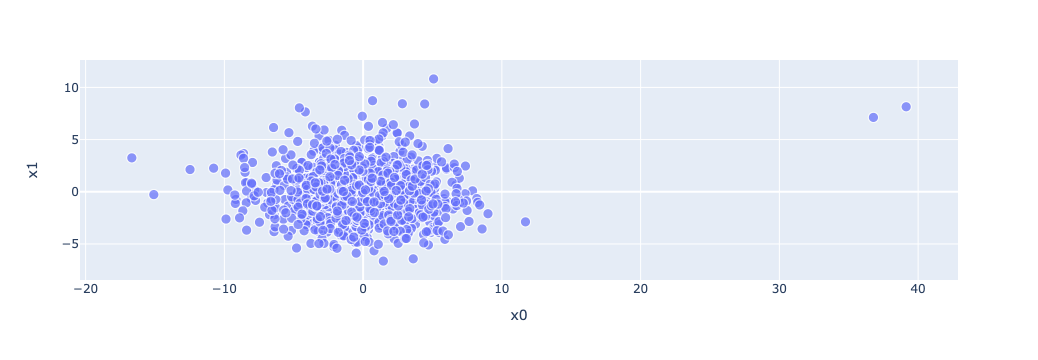

In [53]:
# visualize
import plotly.express as px 
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
import numpy as np

fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 size = list(np.ones(len(embedding_df))),
                 size_max = 10,
                 hover_name = "word")

fig.show()

The lyrics model had training accuracies of around 67%, which suggests that the word embeddings may not be learning as well as we expect. 

However, we can still see a dinstinction among the three genres: 

- Words at the top corner are typical for hip hop lyrics. 
- Words at the bottom corner, around 0 at the x0 axis, seem to be more related to rock, and have a negative valence, as typical rock music does (e.g., band, pain, desperate, nightmare). 
- Words at the left corner appear more in country music (e.g., cowboy, road, Texas). 

Finally, I will try to visualize any clusterings that the embedding model learned by doing a k-mean clustering analysis.

In [ ]:
from sklearn.cluster import KMeans

# perform k-means clustering on the weights matrix
kmeans = KMeans(n_clusters=3, random_state=42).fit(weights)
labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



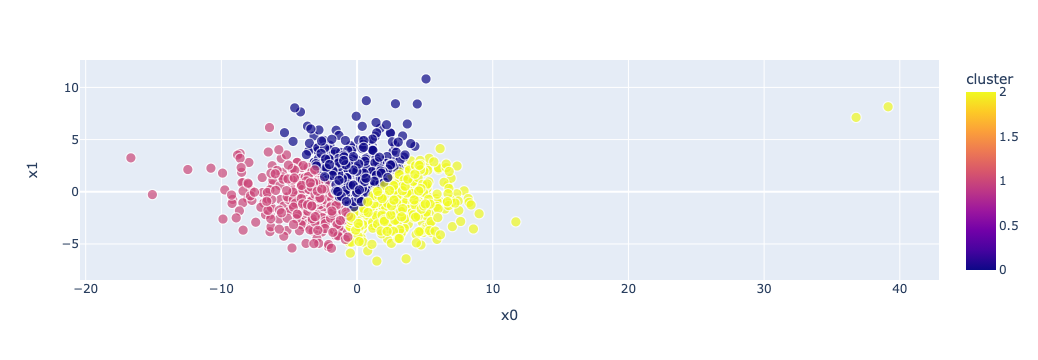

In [54]:
# scatter plot with cluster information
embedding_df = pd.DataFrame({
    "word": tokens, 
    "x0": weights[:,0], 
    "x1": weights[:,1], 
    "cluster": labels
})

fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 color = "cluster",
                 size = list(np.ones(len(embedding_df))),
                 size_max = 10,
                 hover_name = "word")

fig.show()

Looking into the words in the three clusters, it makes sense that the red cluster includes more "country" lyrics, while the blue cluster is hip hop and the yellow cluster is rock. 

## Conclusion
To conclude, I have experimented with using different features and models to classify music by genre. The best performing model used only engineered features about the audio characteristics of the music and achieved a 76% test accuracy. 

Although the models that used lyrics data did not perform better, we see that they have learned valid word embeddings that reflected the styles of the lyrics across the three genres. 

For this attempt, I have chosen three genres that are quite distinctive from each other in terms of lyrics and music style. The models may face more challenges with data that include more genres that differ in a more subtle way. 